# Introduction

I'll be build a very deep convolutional network, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by He et al., allows to train much deeper networks than were previously feasible.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import ZeroPadding2D, MaxPooling2D, Dense, BatchNormalization, Activation
from keras.layers import AveragePooling2D, GlobalMaxPooling2D, Conv2D, Flatten, Add, Input
from keras.initializers import random_uniform, glorot_uniform, constant, identity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : A ResNet block showing a skip-connection <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network.

    
On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."


# The Identify Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 


<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

In [2]:
# Identify Block Building
# X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
# f -- integer, specifying the shape of the middle CONV's window for the main path
# filters -- python list of integers, defining the number of filters in the CONV layers of the main path
# training -- True: Behave in training mode
#             False: Behave in inference mode
# initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X) 

    ## Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step
    X = Activation('relu')(X) 

    return X

#The Conventional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 
* As for the previous exercise, the additional `initializer` argument is required for grading purposes, and it has been set by default to [glorot_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 

In [3]:
#Convolution BLock
# X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
# f -- integer, specifying the shape of the middle CONV's window for the main path
# filters -- python list of integers, defining the number of filters in the CONV layers of the main path
# s -- Integer, specifying the stride to be used
# training -- True: Behave in training mode
#             False: Behave in inference mode
# initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
#                also called Xavier uniform initializer.
    
# Returns:
# X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):

    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path 
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X) 

    ## Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

#Building the ResNet Network(50 layers)

The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.


In [4]:
#Building the Resnet Network 


#input_shape -- shape of the images of the dataset
#classes -- integer, number of classes
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ## Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2) 
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4 
    X = convolutional_block(X, f=3, filters=[256, 256, 1024],s=2) 
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 
    X = convolutional_block(X, f=3, filters=[512, 512, 2048],s=2) 
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL 
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X) 

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


The model is now ready to be trained. The only thing we need now is a dataset!

Let's load our old friend, the SIGNS dataset.


<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 6</b> </u><font color='purple'>  : <b>SIGNS dataset</b> </center></caption>

In [7]:
train = h5py.File('/content/drive/MyDrive/Hand Gesture Model/train_signs.h5', 'r')
test = h5py.File('/content/drive/MyDrive/Hand Gesture Model/test_signs.h5','r')


In [8]:
#Creating the train and test files
x_train = np.array(train['train_set_x'])
y_train = np.array(train['train_set_y'])
x_test = np.array(test['test_set_x'])
y_test = np.array(test['test_set_y'])

x_train = x_train/255.
x_test = x_test/255.

print('x train shape is', x_train.shape)
print('y train shape is', y_train.shape)
print('x test shape is', x_test.shape)
print('y test shape is', y_test.shape)


x train shape is (1080, 64, 64, 3)
y train shape is (1080,)
x test shape is (120, 64, 64, 3)
y test shape is (120,)


In [9]:
#converting the y from being vectors to binary
y_train = keras.utils.to_categorical(y_train, num_classes=6)
y_test = keras.utils.to_categorical(y_test, num_classes=6)

print('y train shape is', y_train.shape)
print('y test shape is', y_test.shape)

y train shape is (1080, 6)
y test shape is (120, 6)


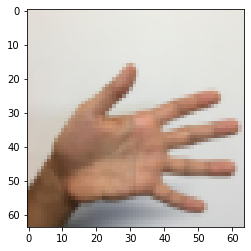

In [10]:
# Data_visualization
plt.imshow(x_train[0])
plt.show()

In [11]:
print(y_train[0])


[0. 0. 0. 0. 0. 1.]


In [15]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
34/34 [==============================] - 6s 88ms/step - loss: 0.7245 - accuracy: 0.6685 - val_loss: 0.6295 - val_accuracy: 0.7250
Epoch 2/50
34/34 [==============================] - 2s 57ms/step - loss: 0.6470 - accuracy: 0.7241 - val_loss: 1.7973 - val_accuracy: 0.6167
Epoch 3/50
34/34 [==============================] - 2s 58ms/step - loss: 0.6607 - accuracy: 0.7426 - val_loss: 0.6366 - val_accuracy: 0.7417
Epoch 4/50
34/34 [==============================] - 2s 57ms/step - loss: 0.5730 - accuracy: 0.8046 - val_loss: 1.0787 - val_accuracy: 0.6333
Epoch 5/50
34/34 [==============================] - 2s 58ms/step - loss: 0.7652 - accuracy: 0.7630 - val_loss: 0.8126 - val_accuracy: 0.7083
Epoch 6/50
34/34 [==============================] - 2s 58ms/step - loss: 0.4895 - accuracy: 0.8463 - val_loss: 0.5295 - val_accuracy: 0.8083
Epoch 7/50
34/34 [==============================] - 2s 57ms/step - loss: 0.4600 - accuracy: 0.8519 - val_loss: 0.5910 - val_accuracy: 0.7833
Epoch 8/50
34

In [16]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 0s 31ms/step - loss: 0.4853 - accuracy: 0.9250
Loss = 0.4852645993232727
Test Accuracy = 0.925000011920929


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

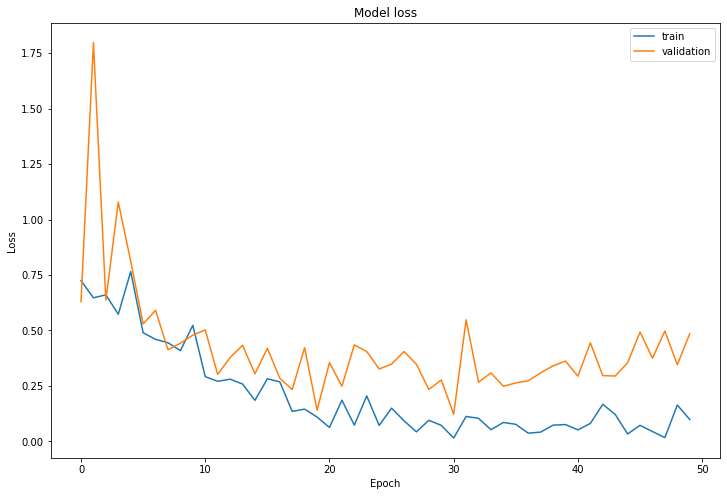

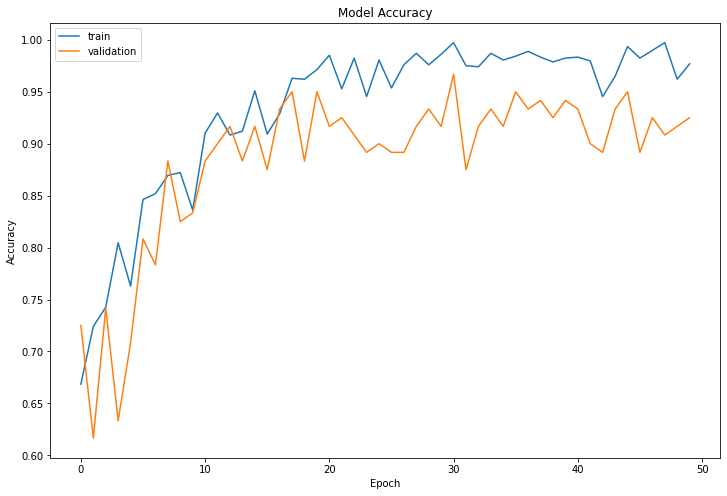

In [17]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')